In [345]:
 #1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime # для работы со времнем
import gc # сборщик мусора

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


# 4. Метирки качества
from sklearn.metrics import  r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [2]:
PREPARED_DATASET_PATH='1data/train.csv'
FINAL_TEST='1data/test.csv'

In [3]:
df=pd.read_csv(PREPARED_DATASET_PATH)
X_final=pd.read_csv(FINAL_TEST)

In [4]:
X=df.copy()

In [5]:
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

1. ID перенесем в индекс

In [6]:
X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.5+ MB


In [8]:
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [9]:
X['DistrictId'] = X['DistrictId'].astype('category')
X['Shops_2'] = X['Shops_2'].astype('category')
X['Ecology_3'] = X['Ecology_3'].astype('category')
X['Ecology_2'] = X['Ecology_2'].astype('category')
X['Rooms'] = X['Rooms'].astype('int8')
X['HouseFloor'] = X['HouseFloor'].astype('int16')


In [10]:
X_final['DistrictId'] = X_final['DistrictId'].astype('category')
X_final['Shops_2'] = X_final['Shops_2'].astype('category')
X_final['Ecology_3'] = X_final['Ecology_3'].astype('category')
X_final['Ecology_2'] = X_final['Ecology_2'].astype('category')
X_final['Rooms'] = X_final['Rooms'].astype('int8')
X_final['HouseFloor'] = X_final['HouseFloor'].astype('int16')

In [11]:
X.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


2. Сформируем стоимость за квадратный метр

In [12]:
X['Price_per_sq']=X['Price']/X['Square']

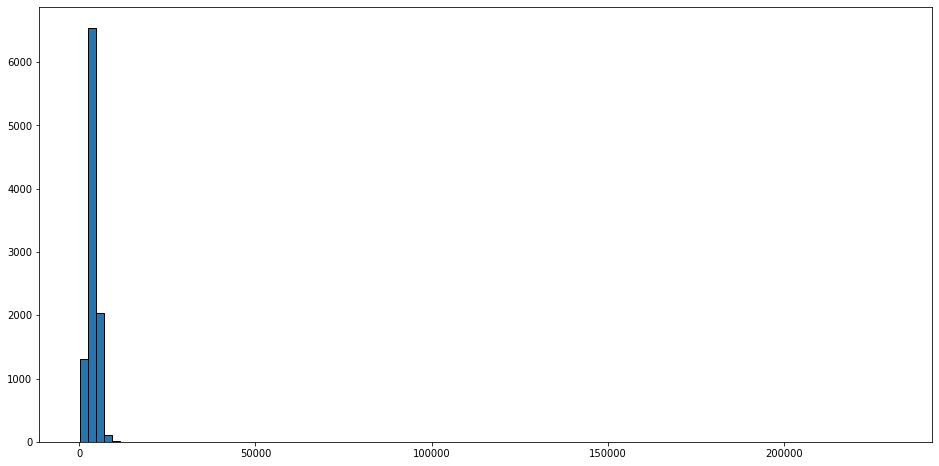

In [13]:
plt.figure(figsize=(16,8))
plt.hist(X['Price_per_sq'],ec="black",bins=100)
plt.show()

Проверим площадь Square маленькие значения

In [14]:
X[X['Square']<=19]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_per_sq
Id,,,,,,,,,,,,,,,,,,,,
1748,88,2,5.497061,67.628717,1.0,24,22,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,75042.110444
11526,27,1,4.633498,1.969969,1.0,18,1,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441,23223.115671
10202,6,1,2.596351,4.604943,1.0,3,25,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458,52996.529388
13685,0,1,17.498542,13.446544,0.0,7,5,1961,0.319809,B,B,25,4756,16,2857.0,5,8,B,88871.750230,5078.808780
15127,150,1,17.046188,20.036232,8.0,7,12,1982,0.300323,B,B,52,10311,6,NaN,1,9,B,74222.110465,4354.176580
10527,27,1,4.380726,40.805837,1.0,10,17,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383,22270.446581
9487,5,1,5.129222,5.549458,1.0,1,1,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,72032.840662
523,101,1,18.509177,15.170851,3.0,5,5,1970,0.225825,A,B,41,6558,7,1548.0,3,2,B,115845.861527,6258.833718
12676,81,3,13.784865,15.988889,7.0,4,5,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186,5686.585073


Если получилось меньше 10, будем считать это опечаткой на порядок

In [15]:
X['Square_outlier']=0

In [16]:
X.loc[X['Square']<10,'Square_outlier']=1

In [17]:
X.loc[X['Square']<10,'Square']=X['Square']*10

In [18]:
X_final['Square_outlier']=0

In [19]:
X_final.loc[X_final['Square']<10,'Square_outlier']=1

In [20]:
X_final.loc[X_final['Square']<10,'Square']=X_final['Square']*10

Пересчитаем стоимость квадрата

In [21]:
X['Price_per_sq']=X['Price']/X['Square']

Проверим площадь на большие значения

In [22]:
X[X['Square']>200]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_per_sq,Square_outlier
Id,,,,,,,,,,,,,,,,,,,,,
7917,27,0,212.932361,211.231125,0.0,2,3,2008,0.211401,B,...,9,1892,0,NaN,0,1,B,302211.260887,1419.282909,0
5548,86,5,275.645284,233.949309,26.0,12,37,2011,0.161976,B,...,31,7010,5,4508.0,3,7,B,455264.882666,1651.633128,0
28,9,2,604.705972,NaN,1.0,17,18,1977,0.161532,B,...,25,5648,1,30.0,2,4,B,187717.242538,310.427301,0
2307,102,1,409.425181,410.639749,10.0,4,4,2016,0.238617,B,...,26,3889,6,705.0,3,6,B,90470.430830,220.969386,0
11602,30,2,641.065193,638.163193,10.0,20,19,2019,0.000078,B,...,22,6398,141,1046.0,3,23,B,133529.681562,208.293451,0
16568,27,4,200.334539,201.627361,25.0,1,2,2013,0.041116,B,...,53,14892,4,NaN,1,4,B,528560.506016,2638.389304,0


Объекты от 400 кв. м это выброс Либо опечатка с размерностью. Это видно по стоимости квадратного метра.  Но в тесте его нет и у меня нет логики что бы и применять его к тесту. Поэтому я просто удалю эти строки.

In [23]:
X.drop(X[X['Square']>400].index,inplace=True)

Разберемся с KitchenSquare

In [24]:
X['KitchenSquare'].value_counts()

1.0       2459
8.0       1306
5.0       1169
10.0      1073
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
37.0         2
32.0         2
30.0         2
58.0         2
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
62.0         1
42.0         1
63.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
53.0         1
54.0         1
Name: KitchenSquare, dtype: int64

За стандарт возмем отношение медианной площади кухни к медианной площади квартиры.
Все отклонения в 4 раза, будем заменять медианой?А так же те что меньше 4

In [25]:
sq_med=X['Square'].median()
kit_med=X['KitchenSquare'].median()
til=kit_med/sq_med
til

0.11425792375267924

In [26]:
X['KitchenSquare_outlier']=0

In [27]:
e=(np.abs(X['KitchenSquare']/X['Square']-til)/til>=4)

In [28]:
X.loc[e,'KitchenSquare_outlier']=1

In [29]:
X.loc[e,'KitchenSquare']=X['Square']*til

In [30]:
X.loc[X['KitchenSquare']<4,'KitchenSquare_outlier']=1

In [31]:
X.loc[X['KitchenSquare']<4,'KitchenSquare']=4

In [32]:
X['KitchenSquare']=X['KitchenSquare'].astype(int)

In [33]:
X['KitchenSquare_outlier']=X['KitchenSquare_outlier'].astype('category')

Сделаем для теста

In [34]:
e=(np.abs(X_final['KitchenSquare']/X_final['Square']-til)/til>=4)

In [35]:
X_final['KitchenSquare_outlier']=0

In [36]:
X_final.loc[e,'KitchenSquare_outlier']=1

In [37]:
X_final.loc[e,'KitchenSquare']=X_final['Square']*til

In [38]:
X_final.loc[X_final['KitchenSquare']<4,'KitchenSquare_outlier']=1

In [39]:
X_final.loc[X_final['KitchenSquare']<4,'KitchenSquare']=4

In [40]:
X_final['KitchenSquare']=X_final['KitchenSquare'].astype(int)

In [41]:
X_final['KitchenSquare_outlier']=X_final['KitchenSquare_outlier'].astype('category')

Займемся LifeSquare

In [42]:
X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3

In [43]:
X_final['LifeSquare_nan'] = X_final['LifeSquare'].isna() * 1

condition = (X_final['LifeSquare'].isna()) &\
                      (~X_final['Square'].isna()) & \
                      (~X_final['KitchenSquare'].isna())
        
X_final.loc[condition, 'LifeSquare'] = X_final.loc[condition, 'Square'] - X_final.loc[condition, 'KitchenSquare'] - 3

In [44]:
X_final['LifeSquare_nan']=X_final['LifeSquare_nan'].astype('category')
X['LifeSquare_nan']=X['LifeSquare_nan'].astype('category')

In [45]:
ls_m=X['LifeSquare'].median()
s_m=X['Square'].median()
k_s=ls_m/s_m
k_s

0.6692736332680215

Будем проверять это соотношение. Если оно меньше 0,3 и больше 0,95. то будем расчитывать классическое

In [46]:
my_str=(X['LifeSquare']/X['Square']>0.95)|(X['LifeSquare']/X['Square']<0.3)

In [47]:
X.loc[my_str,'LifeSquare_nan']=1

In [48]:
X.loc[my_str,'LifeSquare']=X['Square']-X['KitchenSquare']-3

In [49]:
my_str=(X_final['LifeSquare']/X_final['Square']>0.95)|(X_final['LifeSquare']/X_final['Square']<0.3)
X_final.loc[my_str,'LifeSquare_nan']=1
X_final.loc[my_str,'LifeSquare']=X_final['Square']-X_final['KitchenSquare']-3

займемся Room

In [50]:
X['Rooms'].value_counts()

2     3878
1     3704
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

In [51]:
X['Rooms_outlier']=0

In [52]:
X.loc[X['Rooms']==0,'Rooms_outlier']=1

In [53]:
X.loc[X['Rooms']==0,'Rooms']=1

In [54]:
X.loc[X['Rooms']>9,'Rooms_outlier']=1

In [55]:
X.loc[X['Rooms']>9,'Rooms']=1

In [56]:
X['Rooms_outlier']=X['Rooms_outlier'].astype('category')

In [57]:
X_final['Rooms_outlier']=0
X_final.loc[X_final['Rooms']==0,'Rooms_outlier']=1
X_final.loc[X_final['Rooms']==0,'Rooms']=1
X_final.loc[X_final['Rooms']>9,'Rooms_outlier']=1
X_final.loc[X_final['Rooms']>9,'Rooms']=1
X_final['Rooms_outlier']=X_final['Rooms_outlier'].astype('category')

Займемся HouseFloor

In [58]:
X['HouseFloor'].value_counts().sort_index()


0       269
1       497
2        48
3       127
4       133
5      1031
6        58
7        59
8       141
9      1389
10      135
11       28
12     1074
13       27
14      625
15      123
16      576
17     2331
18       88
19      107
20      105
21       33
22      343
23       40
24      176
25      374
26        1
27        6
28        3
29        1
30       21
31        1
32        4
36        1
37        4
38        1
39        2
40        7
44        1
45        1
47        1
48        2
99        2
117       1
Name: HouseFloor, dtype: int64

In [59]:
X['HouseFloor_outlier']=0

In [60]:
X.loc[X['HouseFloor']==0,'HouseFloor_outlier']=1

In [61]:
X.loc[X['HouseFloor']==0,'HouseFloor']=X.loc[X['HouseFloor']==0,'Floor'].max()

In [62]:
X.loc[X['HouseFloor']>60,'HouseFloor_outlier']=1

In [63]:
X.loc[X['HouseFloor']>60,'HouseFloor']=X.loc[X['HouseFloor']>60,'Floor'].max()

In [64]:
X_final['HouseFloor_outlier']=0
X_final.loc[X_final['HouseFloor']==0,'HouseFloor_outlier']=1
X_final.loc[X_final['HouseFloor']==0,'HouseFloor']=X_final.loc[X_final['HouseFloor']==0,'Floor'].max()
X_final.loc[X_final['HouseFloor']>60,'HouseFloor_outlier']=1
X_final.loc[X_final['HouseFloor']>60,'HouseFloor']=X_final.loc[X_final['HouseFloor']>60,'Floor'].max()

Займемся FLOOR

In [65]:
X['Floor'].value_counts().sort_index()

1     235
2     588
3     872
4     948
5     876
6     802
7     759
8     643
9     604
10    553
11    457
12    438
13    398
14    362
15    287
16    290
17    255
18    185
19    121
20     67
21     59
22     54
23     25
24     53
25     34
26     18
27      5
28      3
31      1
32      2
33      1
37      1
42      1
Name: Floor, dtype: int64

In [66]:
X.loc[X['Floor']>X['HouseFloor'],'HouseFloor_outlier']=1

In [67]:
X.loc[X['Floor']>X['HouseFloor'],'HouseFloor']=X['Floor']

In [68]:
X.loc[X['Floor']==0,'HouseFloor_outlier']=1

In [69]:
X.loc[X['Floor']==0,'Floor']=1

In [70]:
X_final.loc[X_final['Floor']>X_final['HouseFloor'],'HouseFloor_outlier']=1
X_final.loc[X_final['Floor']>X_final['HouseFloor'],'HouseFloor']=X_final['Floor']
X_final.loc[X_final['Floor']==0,'HouseFloor_outlier']=1
X_final.loc[X_final['Floor']==0,'Floor']=1

In [71]:
X['HouseFloor_outlier']=X['HouseFloor_outlier'].astype('category')
X_final['HouseFloor_outlier']=X_final['HouseFloor_outlier'].astype('category')

In [72]:
X['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         78
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [73]:
X.loc[X['HouseYear']==20052011,'HouseYear']=2005

In [74]:
X.loc[X['HouseYear']==4968,'HouseYear']=1949

In [75]:
X['Ecology_2'].value_counts().sort_index()

A      97
B    9900
Name: Ecology_2, dtype: int64

In [76]:
dict_cat= {'A': 0, 'B': 1}

In [77]:
X['Ecology_2']=X['Ecology_2'].map(dict_cat)

In [78]:
X['Shops_2']=X['Shops_2'].map(dict_cat)

In [79]:
X_final['Ecology_2']=X_final['Ecology_2'].map(dict_cat)
X_final['Shops_2']=X_final['Shops_2'].map(dict_cat)

In [80]:
X['Ecology_3']=X['Ecology_3'].map(dict_cat)
X_final['Ecology_3']=X_final['Ecology_3'].map(dict_cat)

In [81]:
X.drop('Healthcare_1',axis=1,inplace=True)
X_final.drop('Healthcare_1',axis=1,inplace=True)

In [82]:
X['Price_per_sq']=X['Price']/X['Square']

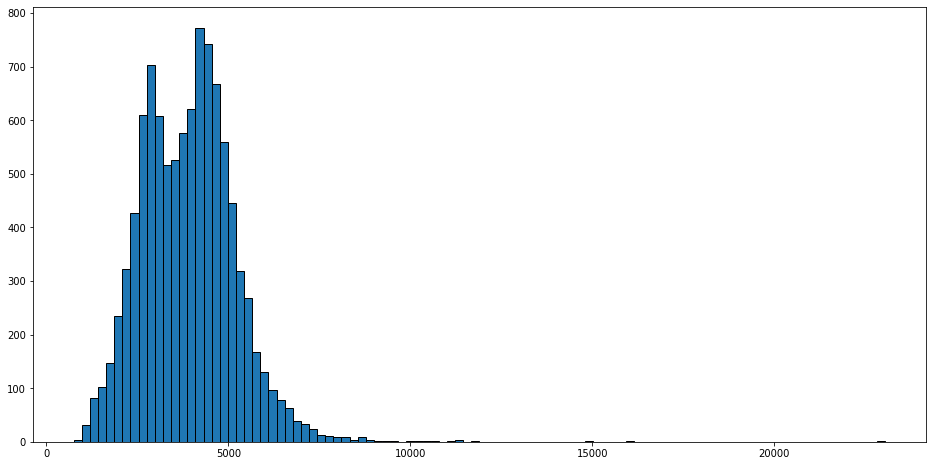

In [83]:
plt.figure(figsize=(16,8))
plt.hist(X['Price_per_sq'],ec="black",bins=100)
plt.show()

In [84]:
X[X['Price_per_sq']<1000]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Price_per_sq,Square_outlier,KitchenSquare_outlier,LifeSquare_nan,Rooms_outlier,HouseFloor_outlier
Id,,,,,,,,,,,,,,,,,,,,,
7590,113,3,94.417148,56.749169,11,6,18,2008,0.050756,1,...,0,1,1,71057.273346,752.588644,0,0,0,0,0
203,33,4,101.554252,89.554252,9,4,5,1958,0.051942,1,...,2,0,1,82342.775873,810.825491,0,0,1,0,0
14825,152,3,88.978324,56.939045,12,7,7,1958,0.042032,1,...,2,5,1,85499.969325,960.907842,0,0,0,0,0
14892,57,3,84.206197,49.920840,8,7,7,2005,0.090799,1,...,5,15,1,71319.376419,846.961137,0,0,0,0,0
6627,36,3,86.594116,54.695269,10,7,17,2008,0.087619,1,...,1,0,1,85537.735405,987.800779,0,0,0,0,0


In [85]:
X.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Price_per_sq,Square_outlier
count,9997.000000,9997.000000,9997.000000,9997.00000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000
mean,1.887766,56.207088,39.719051,6.73442,8.525158,13.863159,1984.858057,0.118853,24.687106,5352.169551,8.026808,1.319096,4.229269,214161.934244,3896.733466,0.001200
std,0.812694,19.083184,18.188173,2.84739,5.239797,6.110533,18.411033,0.119030,17.535219,4007.359551,23.798206,1.493620,4.803361,92874.114626,1275.439517,0.034627
min,1.000000,11.368588,3.784865,4.00000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,752.588644,0.000000
25%,1.000000,41.784525,26.555591,4.00000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153893.979077,2918.726774,0.000000
50%,2.000000,52.512769,34.941912,6.00000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192302.751941,3909.441420,0.000000
75%,2.000000,65.890231,48.440686,9.00000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249174.529858,4691.082695,0.000000
max,6.000000,275.645284,233.949309,43.00000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570,23046.353797,1.000000


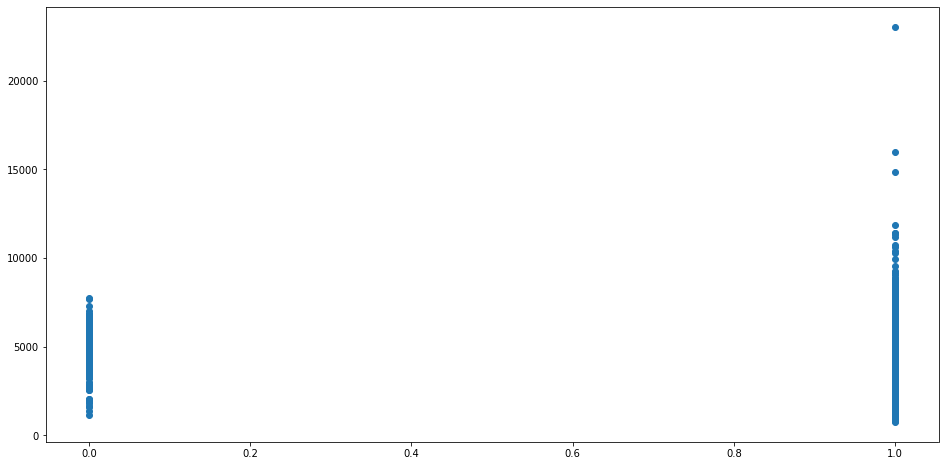

In [86]:
plt.figure(figsize=(16,8))
plt.scatter(X['Ecology_3'],X['Price_per_sq'])
plt.show()

In [87]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 14038 to 6306
Data columns (total 24 columns):
DistrictId               9997 non-null category
Rooms                    9997 non-null int8
Square                   9997 non-null float64
LifeSquare               9997 non-null float64
KitchenSquare            9997 non-null int32
Floor                    9997 non-null int64
HouseFloor               9997 non-null int64
HouseYear                9997 non-null int64
Ecology_1                9997 non-null float64
Ecology_2                9997 non-null category
Ecology_3                9997 non-null category
Social_1                 9997 non-null int64
Social_2                 9997 non-null int64
Social_3                 9997 non-null int64
Helthcare_2              9997 non-null int64
Shops_1                  9997 non-null int64
Shops_2                  9997 non-null category
Price                    9997 non-null float64
Price_per_sq             9997 non-null float64
Square_outlie

Цены  меньше 1000 долларов за метр без внятных причин, буду считать выбросом и удали эти строки

In [88]:
X.drop(X[X['Price_per_sq']<1000].index,inplace=True)

In [89]:
X[X['Price_per_sq']>10000]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Price_per_sq,Square_outlier,KitchenSquare_outlier,LifeSquare_nan,Rooms_outlier,HouseFloor_outlier
Id,,,,,,,,,,,,,,,,,,,,,
6036,95,1,46.248238,39.248238,4,5,26,1977,0.000699,1,...,0,3,1,516315.770611,11164.009578,0,1,1,0,1
10919,190,2,47.489415,35.564479,4,5,5,1918,0.000000,1,...,5,5,1,537979.657509,11328.412026,0,0,0,0,0
11013,43,2,58.757047,34.605286,8,12,17,2004,0.000078,1,...,3,23,1,625678.644994,10648.571986,0,0,0,0,0
2018,94,1,33.521641,30.155171,4,17,17,2015,0.282798,1,...,0,6,1,381912.162109,11393.003236,0,1,0,0,1
5632,17,3,54.036554,43.891272,8,6,21,2017,0.093443,1,...,2,4,1,556053.820499,10290.327151,0,0,0,0,0
14786,1,1,11.368588,4.525736,4,3,3,1977,0.007122,1,...,0,1,1,181434.825589,15959.310792,1,1,0,0,1
12927,62,2,17.414181,10.414181,4,4,20,1977,0.072158,1,...,0,0,0,180750.471749,10379.498777,0,1,1,0,0
7931,181,1,34.911269,18.433155,6,10,12,1955,0.000000,1,...,1,8,1,397528.736061,11386.831424,0,0,0,0,0
15744,34,1,19.889427,12.889427,4,21,21,1977,0.069753,1,...,1,11,1,458378.777006,23046.353797,1,1,1,0,1


Наблюдения более 10 000 долл за кв метр я удалю

In [90]:
X.drop(X[X['Price_per_sq']>10000].index,inplace=True)

На этом уровень1 обработки закончен

In [91]:
y_train=X['Price']
y1_train=X['Price_per_sq']

In [92]:
X_train=X.drop(['Price','Price_per_sq'],axis=1)

In [93]:
X.to_csv('data/X_1')
X_final.to_csv('data/X_final_1')

In [94]:
def cross_val_LGBMR(df,y,max_depth=18,learning_rate=0.1,n_estimators=105,num_leaves=32,random_state=42):
    model_LGBMR = LGBMRegressor(max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,num_leaves=num_leaves,
                                random_state=random_state)
    cv_score = cross_val_score(model_LGBMR, df, y,  scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
    mean = cv_score.mean()
    std = cv_score.std()
    print('R2: {:.3f} +- {:.3f}'.format(mean, std))

In [207]:
def gs_LGBMR(df,y,params_LGBMR):
    model_LGBMR = LGBMRegressor(random_state=42)
    gs_rtr = GridSearchCV(model_LGBMR,params_LGBMR, 
                      scoring='r2', # метрика 
                      cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                               random_state=21, 
                               shuffle=True), 
                      n_jobs=-1  # Кол-во потоков
                          )
    gs_rtr.fit(df,y)  # НА TRAIN!
    print(gs_rtr.best_score_,gs_rtr.best_params_) 

In [96]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

In [97]:
def final_model(train,target,final,pd,n,max_depth,learning_rate,n_estimators,num_leaves,random_state=42): 
    model_LGBMR = LGBMRegressor(max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,num_leaves=num_leaves,
                                random_state=random_state)
    model_LGBMR.fit(train, target)
    y_pred_final_LGBMR=model_LGBMR.predict(final)
    pd['Price'] = y_pred_final_LGBMR
    pd.to_csv('data/predictions_LGBMR_'+str(n)+'.csv', index=False)
    preds_final.head()

Линеная регрессия

In [98]:
model= LinearRegression()

In [99]:
cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.553 +- 0.020


In [100]:
# model.fit(X_train, y_train)

In [101]:
# y_pred_final=model.predict(X_final)

In [102]:
# preds_final['Price'] = y_pred_final
# preds_final.to_csv('data/predictions_lr_1.csv', index=False)

# preds_final.head()

DecisionTreeRegressor

In [103]:
# model_dtr = DecisionTreeRegressor(random_state=42)

In [104]:
# params_dtr={'criterion':['mse'],'max_depth':[ 10,15,18,20,25,30],'min_samples_leaf':[15,20,25,30,35,40]}

In [105]:
# gs_dtr = GridSearchCV(model_dtr, params_dtr, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True), 
#                   n_jobs=-1  # Кол-во потоков 
#                  )


In [106]:
# gs_dtr.fit(X_train, y_train)  # НА TRAIN!

In [107]:
# gs_dtr.best_score_

In [108]:
# gs_dtr.best_params_

In [109]:
# model_dtr_final = DecisionTreeRegressor(random_state=42,criterion= 'mse',max_depth= 18,min_samples_leaf=25)
# model_dtr_final.fit(X_train,y_train)

In [110]:
# y_pred_final_dtr=model_dtr_final.predict(X_final)
# preds_final['Price'] = y_pred_final_dtr
# preds_final.to_csv('data/predictions_dtr_1.csv', index=False)
# preds_final.head()

In [111]:
# model_rfr = RandomForestRegressor(random_state=42)
# params_rfr={'n_estimators':[400],'criterion':['mse'],'max_depth':[17],
#         'min_samples_leaf':[4],'max_features': [7]}

In [112]:
# gs_rtr = GridSearchCV(model_rfr, params_rfr, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True), 
#                   n_jobs=-1  # Кол-во потоков
#                  )
# gs_rtr.fit(X_train, y_train)  # НА TRAIN!
# gs_rtr.best_score_
# gs_rtr.best_params_

Случайный лес

In [113]:
model_rfr = RandomForestRegressor(random_state=42,n_estimators=400,max_depth=17,min_samples_leaf=4,max_features=7)
model_rfr.fit(X_train, y_train)

In [114]:
cv_score = cross_val_score(model_rfr, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

In [115]:
# model_rfr.fit(X_train, y_train)
# y_pred_final_rfr=model_rfr.predict(X_final)
# preds_final['Price'] = y_pred_final_rfr
# preds_final.to_csv('data/predictions_rfr_1.csv', index=False)
# preds_final.head()

LGBMRegressor

In [116]:
# model_LGBMR = LGBMRegressor(random_state=42)
# params_LGBMR={'n_estimators':[105,104,106],'max_depth':[17],'learning_rate': [0.1], 'num_leaves':[33]}

In [117]:
# gs_rtr = GridSearchCV(model_LGBMR,params_LGBMR, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True), 
#                   n_jobs=-1  # Кол-во потоков
#                  )
# gs_rtr.fit(X_train, y_train)  # НА TRAIN!
# print(gs_rtr.best_score_,gs_rtr.best_params_) 


In [118]:
model_LGBMR = LGBMRegressor(max_depth=17,
                             learning_rate=0.1,
                             n_estimators=105,
                             num_leaves=33,
                             random_state=42)

In [119]:
cv_score = cross_val_score(model_LGBMR, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.759 +- 0.023


In [120]:
# model_LGBMR.fit(X_train, y_train)
# y_pred_final_LGBMR=model_LGBMR.predict(X_final)
# preds_final['Price'] = y_pred_final_LGBMR
# preds_final.to_csv('data/predictions_LGBMR_1.csv', index=False)
# preds_final.head()

Предсказние по цене квадратного метра, не стоит предсказывать

In [121]:
model_LGBMR = LGBMRegressor(max_depth=17,
                             learning_rate=0.1,
                             n_estimators=105,
                             num_leaves=33,
                             random_state=42)

In [122]:
cv_score = cross_val_score(model_LGBMR, X_train, y1_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.656 +- 0.027


In [123]:
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Price_per_sq,Square_outlier,KitchenSquare_outlier,LifeSquare_nan,Rooms_outlier,HouseFloor_outlier
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,1,...,0,11,1,184966.930730,3854.958571,0,0,0,0,0
15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,1,...,1,16,1,300009.450063,4567.491245,0,0,0,0,0
4765,53,2,44.947953,29.197612,4,8,12,1968,0.049637,1,...,1,3,1,220925.908524,4915.149522,0,1,0,0,0
5809,58,2,53.352981,41.352981,9,8,17,1977,0.437885,1,...,0,5,1,175616.227217,3291.591637,0,0,1,0,0
10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,1,...,2,4,1,150226.531644,3788.892642,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2,50.401785,30.476203,5,6,6,1968,0.135650,1,...,3,11,1,196684.316040,3902.328381,0,0,0,0,1
6159,18,1,41.521546,20.539216,9,13,13,2000,0.000000,1,...,0,5,0,189050.289571,4553.064815,0,0,0,0,0
5123,27,1,47.939008,40.939008,4,12,16,2015,0.072158,1,...,0,0,0,159143.805370,3319.714218,0,1,1,0,0


In [124]:
X['Shops_1'].value_counts()

0     2313
1     1323
5     1321
2      963
4      839
3      710
6      485
11     400
9      316
7      293
8      252
23     243
10     215
15     175
16      83
19      49
Name: Shops_1, dtype: int64

In [125]:
X['Helthcare_2'].value_counts()

0    4208
1    2180
3    1666
2    1154
5     385
4     288
6      99
Name: Helthcare_2, dtype: int64

In [126]:
X['DistrictId'].value_counts()

27     851
1      651
23     565
6      511
9      293
      ... 
117      1
199      1
196      1
174      1
209      1
Name: DistrictId, Length: 205, dtype: int64

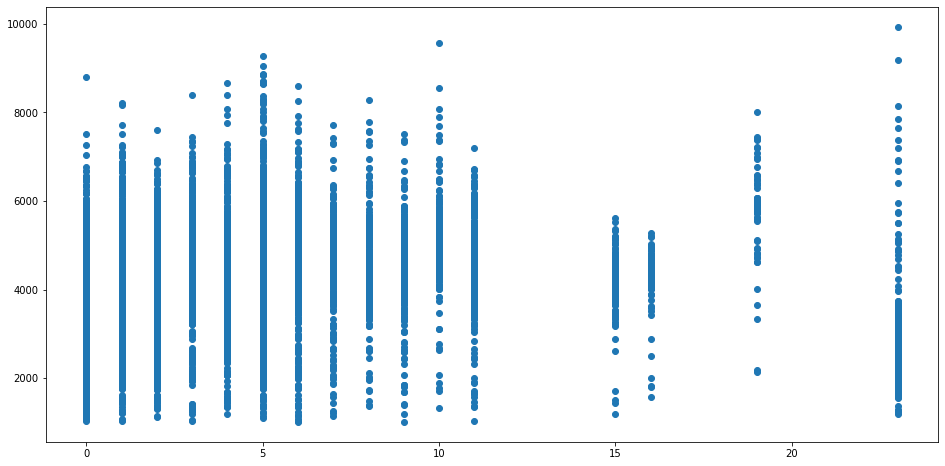

In [127]:
plt.figure(figsize=(16,8))
plt.scatter(X['Shops_1'],X['Price_per_sq'])
plt.show()

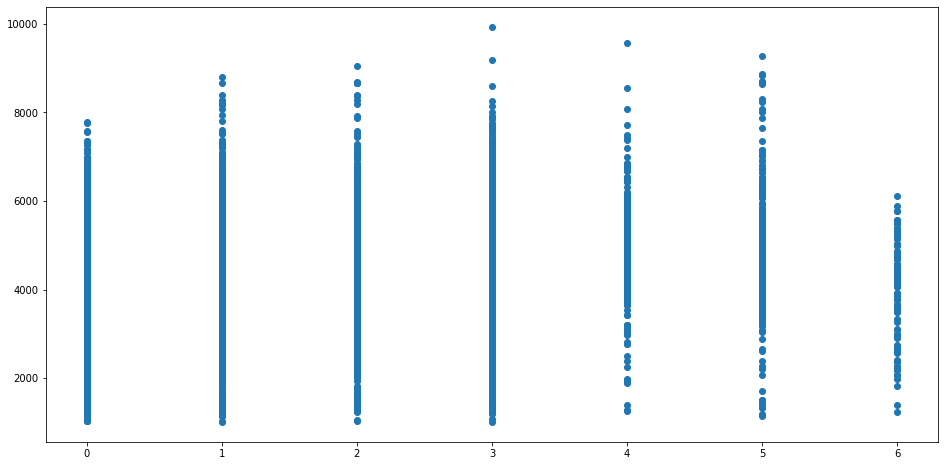

In [128]:
plt.figure(figsize=(16,8))
plt.scatter(X['Helthcare_2'],X['Price_per_sq'])
plt.show()

Введем медианную стоимость в раойне

In [129]:
district = X['DistrictId'].value_counts()
district = district[district > 50]

In [130]:
DistrictId_counts = dict(district)

In [131]:
price_discrit=X.groupby(['DistrictId']).agg({'Price_per_sq':'median'})
price_discrit

,Price_per_sq
DistrictId,
0,3935.906409
1,3251.274406
2,4550.709250
3,3892.203737
4,5716.888354
...,...
202,3040.402573
205,5101.016598
207,5550.678339


In [132]:
price_discrit_popular=price_discrit[price_discrit.index.isin(district.keys().tolist())]

In [133]:
len(price_discrit_popular)

55

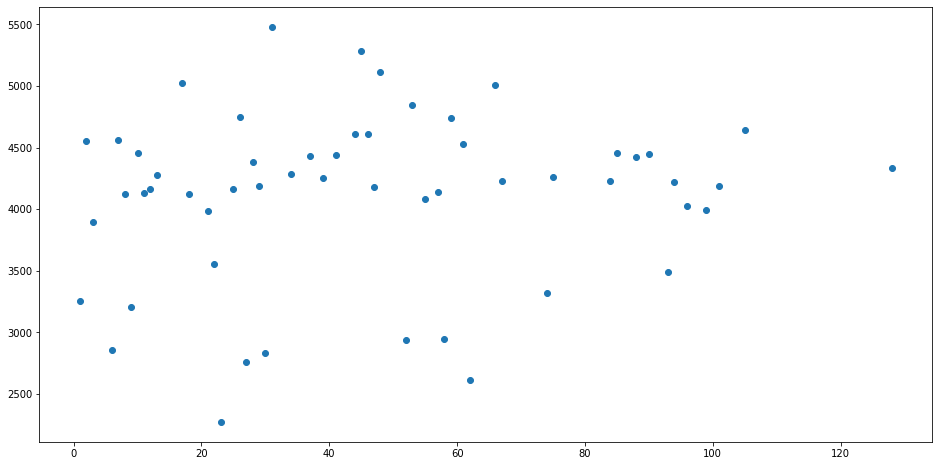

In [134]:
plt.figure(figsize=(16,8))
plt.scatter(price_discrit_popular.index,price_discrit_popular['Price_per_sq'])
plt.show()

In [135]:
my_dict={}
for i in list(price_discrit_popular.index):
    my_dict[i]=price_discrit_popular.loc[price_discrit_popular.index==i,'Price_per_sq'][0]

In [136]:
X['District_Price_sq'] = X['DistrictId'].map(my_dict)

In [137]:
X_final['District_Price_sq'] = X_final['DistrictId'].map(my_dict)

In [138]:
X['District_Price_sq'].value_counts()

2759.201321    851
3251.274406    651
2273.498737    565
2861.079293    511
3207.419491    293
2611.022221    246
2832.095098    227
2949.975415    179
4845.919064    174
3986.568170    165
2938.048239    143
4124.217673    142
4134.353749    129
4608.809057    119
4528.020926    118
5286.848514    115
3319.318045    114
4285.831801    110
4141.035343    106
4610.399155    104
3992.031265     97
4181.963615     97
4273.749207     97
4188.414745     97
4562.026777     92
5115.764637     90
4186.662748     89
4219.667931     88
4437.304072     87
3892.203737     82
4229.546395     80
4385.488771     79
4550.709250     78
3553.678687     78
4166.864688     77
4452.225270     76
3494.426936     73
4451.242829     72
4430.244622     72
4025.341982     71
4736.631611     67
4262.324104     66
4745.150770     65
4162.240020     64
4424.291635     64
4333.671199     64
5003.889500     62
4229.830133     61
4081.401851     58
5024.643420     58
4249.133232     57
4458.893222     56
4644.689214 

In [139]:
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Price,Price_per_sq,Square_outlier,KitchenSquare_outlier,LifeSquare_nan,Rooms_outlier,HouseFloor_outlier,District_Price_sq
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,1,...,11,1,184966.930730,3854.958571,0,0,0,0,0,NaN
15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,1,...,16,1,300009.450063,4567.491245,0,0,0,0,0,4437.304072
4765,53,2,44.947953,29.197612,4,8,12,1968,0.049637,1,...,3,1,220925.908524,4915.149522,0,1,0,0,0,4845.919064
5809,58,2,53.352981,41.352981,9,8,17,1977,0.437885,1,...,5,1,175616.227217,3291.591637,0,0,1,0,0,2949.975415
10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,1,...,4,1,150226.531644,3788.892642,0,0,0,0,0,3992.031265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2,50.401785,30.476203,5,6,6,1968,0.135650,1,...,11,1,196684.316040,3902.328381,0,0,0,0,1,NaN
6159,18,1,41.521546,20.539216,9,13,13,2000,0.000000,1,...,5,0,189050.289571,4553.064815,0,0,0,0,0,4120.025201
5123,27,1,47.939008,40.939008,4,12,16,2015,0.072158,1,...,0,0,159143.805370,3319.714218,0,1,1,0,0,2759.201321


Попробуем поспотреть скор при минимальном количестве фич

In [140]:
del_columns=[
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Price_per_sq',
 'Square_outlier',
 'KitchenSquare_outlier',
 'LifeSquare_nan',
 'Rooms_outlier',
 'HouseFloor_outlier']

In [141]:
X_tt=X.drop(del_columns,axis=1)
X_tt

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,District_Price_sq
Id,,,,,,,,,
14038,35,2,47.981561,29.442751,6,7,9,1969,NaN
15053,41,3,65.683640,40.049543,8,7,9,1978,4437.304072
4765,53,2,44.947953,29.197612,4,8,12,1968,4845.919064
5809,58,2,53.352981,41.352981,9,8,17,1977,2949.975415
10783,99,1,39.649192,23.776169,7,11,12,1976,3992.031265
...,...,...,...,...,...,...,...,...,...
77,32,2,50.401785,30.476203,5,6,6,1968,NaN
6159,18,1,41.521546,20.539216,9,13,13,2000,4120.025201
5123,27,1,47.939008,40.939008,4,12,16,2015,2759.201321


In [142]:
cross_val_LGBMR(X_tt,y_train)

R2: 0.744 +- 0.023


In [143]:
X_train_1=X.drop(['Price','Price_per_sq'],axis=1)

In [144]:
model_LGBMR = LGBMRegressor(max_depth=19,
                             learning_rate=0.1,
                             n_estimators=103,
                             num_leaves=32,
                             random_state=42)

In [145]:
cv_score = cross_val_score(model_LGBMR, X_train_1, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.764 +- 0.025


In [146]:
# model_model_LGBMRLGBMR = LGBMRegressor(random_state=42)
# params_LGBMR={'n_estimators':[103],'max_depth':[19],'learning_rate': [0.1], 'num_leaves':[32]}

In [147]:
# gs_rtr = GridSearchCV(model_LGBMR,params_LGBMR, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True), 
#                   n_jobs=-1  # Кол-во потоков
#                  )
# gs_rtr.fit(X_train_1, y_train)  # НА TRAIN!
# print(gs_rtr.best_score_,gs_rtr.best_params_) 

In [148]:
# model_LGBMR = LGBMRegressor(max_depth=19,
#                              learning_rate=0.1,
#                              n_estimators=103,
#                              num_leaves=32,
#                              random_state=42)

In [149]:
# model_LGBMR.fit(X_train_1, y_train)
# y_pred_final_LGBMR=model_LGBMR.predict(X_final)
# preds_final['Price'] = y_pred_final_LGBMR
# preds_final.to_csv('data/predictions_LGBMR_2.csv', index=False)
# preds_final.head()

Добавим фичу с медианой стоимости квартир по району

In [150]:
# full_price_discrit=X.groupby(['DistrictId']).agg({'Price':'median'})

In [151]:
# full_price_discrit_popular=full_price_discrit[full_price_discrit.index.isin(district.keys().tolist())]

In [152]:
# plt.figure(figsize=(16,8))
# plt.scatter(full_price_discrit_popular.index,full_price_discrit_popular['Price'])
# plt.show()

In [153]:
# my_dict={}
# for i in list(full_price_discrit_popular.index):
#     my_dict[i]=full_price_discrit_popular.loc[full_price_discrit_popular.index==i,'Price'][0]
# my_dict    
    

In [154]:
# X['District_Price'] = X['DistrictId'].map(my_dict)

In [155]:
# X_final['District_Price'] = X_final['DistrictId'].map(my_dict)

Показатели ухудшились


In [156]:
# X=X.drop('District_Price',axis=1)
# X_final=X_final.drop('District_Price',axis=1)

Разобъем по годам постройки дома

In [157]:
X['year_cat'] = np.nan
        
X.loc[X['HouseYear'] < 1935, 'year_cat'] = 1
X.loc[(X['HouseYear'] >= 1935) & (X['HouseYear'] <= 1946), 'year_cat'] = 2
X.loc[(X['HouseYear'] > 1946) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 1990), 'year_cat'] = 4
X.loc[(X['HouseYear'] > 1990) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
X['year_cat']=X['year_cat'].astype('category')

In [158]:
X_final['year_cat'] = np.nan
        
X_final.loc[X_final['HouseYear'] < 1935, 'year_cat'] = 1
X_final.loc[(X_final['HouseYear'] >= 1935) & (X_final['HouseYear'] <= 1946), 'year_cat'] = 2
X_final.loc[(X_final['HouseYear'] > 1946) & (X_final['HouseYear'] <= 1980), 'year_cat'] = 3
X_final.loc[(X_final['HouseYear'] > 1980) & (X_final['HouseYear'] <= 1990), 'year_cat'] = 4
X_final.loc[(X_final['HouseYear'] > 1990) & (X_final['HouseYear'] <= 2010), 'year_cat'] = 5
X_final.loc[(X_final['HouseYear'] > 2010), 'year_cat'] = 6
X_final['year_cat']=X_final['year_cat'].astype('category')

In [159]:
X['year_cat'].value_counts()

3.0    5843
6.0    1652
5.0    1548
4.0     865
1.0      38
2.0      34
Name: year_cat, dtype: int64

In [160]:
full_price_year=X.groupby(['year_cat']).agg({'Price_per_sq':'median'})

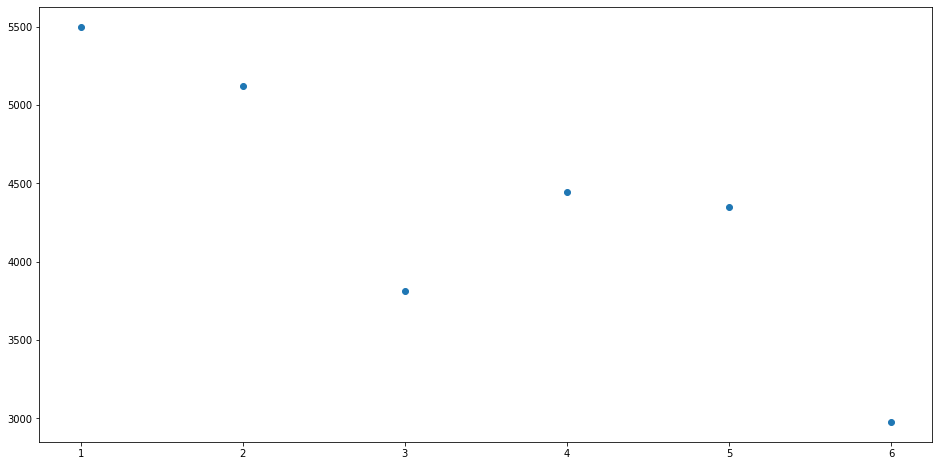

In [161]:
plt.figure(figsize=(16,8))
plt.scatter(full_price_year.index,full_price_year['Price_per_sq'])
plt.show()

In [162]:
my_dict={}
for i in list(full_price_year.index):
    my_dict[i]=full_price_year.loc[full_price_year.index==i,'Price_per_sq'][0]
my_dict  

{1.0: 5500.21374641577,
 2.0: 5123.397184896557,
 3.0: 3814.5079259275926,
 4.0: 4447.681697665508,
 5.0: 4348.981975330193,
 6.0: 2976.2627817582006}

In [163]:
X['yaer_cat_Price'] = X['year_cat'].map(my_dict)

In [164]:
X_final['yaer_cat_Price'] = X_final['year_cat'].map(my_dict)

In [165]:
X_train_2=X.drop(['Price','Price_per_sq'],axis=1)

In [166]:
model_LGBMR = LGBMRegressor(max_depth=18,
                             learning_rate=0.1,
                             n_estimators=105,
                             num_leaves=32,
                             random_state=42)

In [167]:
cv_score = cross_val_score(model_LGBMR, X_train_2, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.763 +- 0.025


In [168]:
# model_LGBMR = LGBMRegressor(random_state=42)
# params_LGBMR={'n_estimators':[105],'max_depth':[18],'learning_rate': [0.1], 'num_leaves':[31,32,33]}

In [169]:
# gs_rtr = GridSearchCV(model_LGBMR,params_LGBMR, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True), 
#                   n_jobs=-1  # Кол-во потоков
#                  )
# gs_rtr.fit(X_train_2, y_train)  # НА TRAIN!
# print(gs_rtr.best_score_,gs_rtr.best_params_) 

In [170]:
X_train_2

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Square_outlier,KitchenSquare_outlier,LifeSquare_nan,Rooms_outlier,HouseFloor_outlier,District_Price_sq,year_cat,yaer_cat_Price
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,1,...,11,1,0,0,0,0,0,NaN,3.0,3814.507926
15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,1,...,16,1,0,0,0,0,0,4437.304072,3.0,3814.507926
4765,53,2,44.947953,29.197612,4,8,12,1968,0.049637,1,...,3,1,0,1,0,0,0,4845.919064,3.0,3814.507926
5809,58,2,53.352981,41.352981,9,8,17,1977,0.437885,1,...,5,1,0,0,1,0,0,2949.975415,3.0,3814.507926
10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,1,...,4,1,0,0,0,0,0,3992.031265,3.0,3814.507926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2,50.401785,30.476203,5,6,6,1968,0.135650,1,...,11,1,0,0,0,0,1,NaN,3.0,3814.507926
6159,18,1,41.521546,20.539216,9,13,13,2000,0.000000,1,...,5,0,0,0,0,0,0,4120.025201,5.0,4348.981975
5123,27,1,47.939008,40.939008,4,12,16,2015,0.072158,1,...,0,0,0,1,1,0,0,2759.201321,6.0,2976.262782


In [171]:
# model_LGBMR.fit(X_train_2, y_train)
# y_pred_final_LGBMR=model_LGBMR.predict(X_final)
# preds_final['Price'] = y_pred_final_LGBMR
# preds_final.to_csv('data/predictions_LGBMR_3.csv', index=False)
# preds_final.head()

Поработаем с Ecology_1

In [172]:
X['Ecology_1_cat'] = np.nan
        
X.loc[X['Ecology_1'] < 0.1, 'Ecology_1_cat'] = 1
X.loc[(X['Ecology_1'] >= 0.1) & (X['Ecology_1'] <= 0.2), 'Ecology_1_cat'] = 2
X.loc[(X['Ecology_1'] > 0.2) & (X['Ecology_1'] <= 0.3), 'Ecology_1_cat'] = 3
X.loc[(X['Ecology_1'] > 0.3) & (X['Ecology_1'] <= 0.4), 'Ecology_1_cat'] = 4
X.loc[(X['Ecology_1'] > 0.4) & (X['Ecology_1'] <= 0.5), 'Ecology_1_cat'] = 5
X.loc[(X['Ecology_1'] > 0.5), 'Ecology_1_cat'] = 6
X['Ecology_1_cat']=X['Ecology_1_cat'].astype('category')

In [173]:
X_final['Ecology_1_cat'] = np.nan
        
X_final.loc[X_final['Ecology_1'] < 0.1, 'Ecology_1_cat'] = 1
X_final.loc[(X_final['Ecology_1'] >= 0.1) & (X_final['Ecology_1'] <= 0.2), 'Ecology_1_cat'] = 2
X_final.loc[(X_final['Ecology_1'] > 0.2) & (X_final['Ecology_1'] <= 0.3), 'Ecology_1_cat'] = 3
X_final.loc[(X_final['Ecology_1'] > 0.3) & (X_final['Ecology_1'] <= 0.4), 'Ecology_1_cat'] = 4
X_final.loc[(X_final['Ecology_1'] > 0.4) & (X_final['Ecology_1'] <= 0.5), 'Ecology_1_cat'] = 5
X_final.loc[(X_final['Ecology_1'] > 0.5), 'Ecology_1_cat'] = 6
X_final['Ecology_1_cat']=X_final['Ecology_1_cat'].astype('category')

In [174]:
Ec_1_med=X.groupby(['Ecology_1_cat']).agg({'Price_per_sq':'median'})

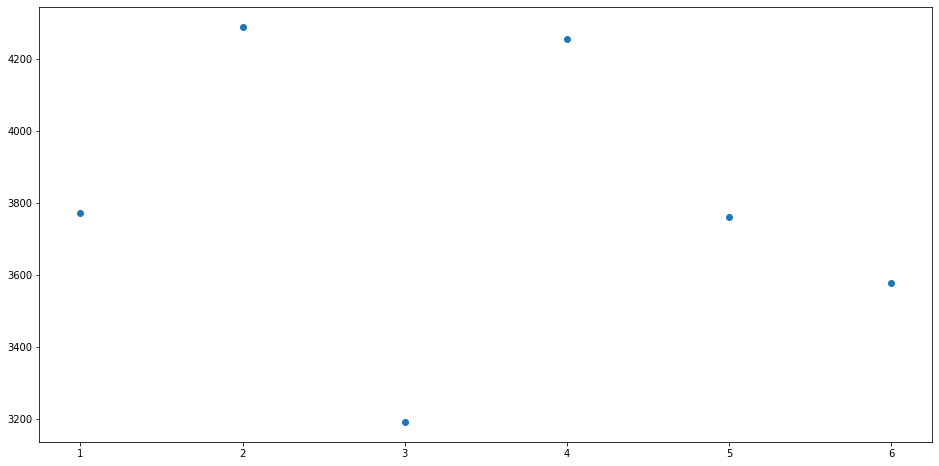

In [175]:
plt.figure(figsize=(16,8))
plt.scatter(Ec_1_med.index,Ec_1_med['Price_per_sq'])
plt.show()

In [176]:
my_dict={}
for i in list(Ec_1_med.index):
    my_dict[i]=Ec_1_med.loc[Ec_1_med.index==i,'Price_per_sq'][0]
my_dict  

{1.0: 3773.112675150239,
 2.0: 4289.918950121651,
 3.0: 3191.3011190052666,
 4.0: 4255.127063209964,
 5.0: 3760.9571821714408,
 6.0: 3577.936984531854}

In [177]:
X['ec_1_cat_Price'] = X['Ecology_1_cat'].map(my_dict)

In [178]:
X_final['ec_1_cat_Price'] = X_final['Ecology_1_cat'].map(my_dict)

In [179]:
cross_val_LGBMR(X.drop(['Price','Price_per_sq'],axis=1),y_train)

R2: 0.762 +- 0.024


Ecology_2

In [180]:
X['Ecology_2'].value_counts()

1    9883
0      97
Name: Ecology_2, dtype: int64

In [181]:
med=X.groupby(['Ecology_2']).agg({'Price_per_sq':'median'})
my_dict={}
for i in list(med.index):
    my_dict[i]=med.loc[med.index==i,'Price_per_sq'].values[0]
X['ec_2_cat_Price'] = X['Ecology_2'].map(my_dict) 

In [182]:
X_final['ec_2_cat_Price'] = X_final['Ecology_2'].map(my_dict) 

Ecology_3

In [183]:
med=X.groupby(['Ecology_3']).agg({'Price_per_sq':'median'})
my_dict={}
for i in list(med.index):
    my_dict[i]=med.loc[med.index==i,'Price_per_sq'].values[0]
X['ec_3_cat_Price'] = X['Ecology_3'].map(my_dict) 

In [184]:
X_final['ec_3_cat_Price'] = X_final['Ecology_3'].map(my_dict) 

In [185]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9980 entries, 14038 to 6306
Data columns (total 31 columns):
DistrictId               9980 non-null category
Rooms                    9980 non-null int8
Square                   9980 non-null float64
LifeSquare               9980 non-null float64
KitchenSquare            9980 non-null int32
Floor                    9980 non-null int64
HouseFloor               9980 non-null int64
HouseYear                9980 non-null int64
Ecology_1                9980 non-null float64
Ecology_2                9980 non-null category
Ecology_3                9980 non-null category
Social_1                 9980 non-null int64
Social_2                 9980 non-null int64
Social_3                 9980 non-null int64
Helthcare_2              9980 non-null int64
Shops_1                  9980 non-null int64
Shops_2                  9980 non-null category
Price                    9980 non-null float64
Price_per_sq             9980 non-null float64
Square_outlie

In [186]:
X[['Social_1','Social_2','Social_3']]

,Social_1,Social_2,Social_3
Id,,,
14038,33,7976,5
15053,46,10309,1
4765,34,7759,0
5809,23,5735,3
10783,35,5776,1
...,...,...,...
77,46,7960,6
6159,30,5562,0
5123,2,629,1


Social_1

In [187]:
X['Social_1'].value_counts()

2     687
1     653
25    556
5     528
30    463
23    432
6     377
22    365
53    354
34    311
33    251
46    245
31    243
43    238
9     213
36    209
21    207
37    204
24    204
52    201
0     201
35    200
47    177
74    175
39    159
27    151
28    144
4     141
11    138
42    129
26    126
16    123
19    118
66     99
17     95
49     95
18     92
32     87
41     83
50     79
29     70
38     64
8      60
15     50
20     50
14     45
10     24
13     22
12     18
7      15
3       9
Name: Social_1, dtype: int64

In [188]:
popular=X['Social_1'].value_counts()
med=X.groupby(['Social_1']).agg({'Price_per_sq':'median'})
my_dict={}
for i in list(med.index):
    if popular[i]>=50:  
        my_dict[i]=med.loc[med.index==i,'Price_per_sq'].values[0]
X['Social_1_cat_Price'] = X['Social_1'].map(my_dict) 

In [189]:
X_final['Social_1_cat_Price'] = X_final['Social_1'].map(my_dict) 

Social_3

In [190]:
X['Social_3'].value_counts()

0      2996
1      1858
3      1136
4       834
2       632
6       421
5       389
141     243
9       192
7       183
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       42
24       36
59       25
93       25
87       25
19       22
20       19
23       18
39       15
73       10
45        9
37        2
Name: Social_3, dtype: int64

In [191]:
popular=X['Social_3'].value_counts()
med=X.groupby(['Social_3']).agg({'Price_per_sq':'median'})
my_dict={}
for i in list(med.index):
    if popular[i]>=50:
        my_dict[i]=med.loc[med.index==i,'Price_per_sq'].values[0]
X['Social_3_cat_Price'] = X['Social_3'].map(my_dict)

In [192]:
X_final['Social_3_cat_Price'] = X_final['Social_3'].map(my_dict)

In [193]:
X[['Helthcare_2','Shops_1','Shops_2']]

,Helthcare_2,Shops_1,Shops_2
Id,,,
14038,0,11,1
15053,1,16,1
4765,1,3,1
5809,0,5,1
10783,2,4,1
...,...,...,...
77,3,11,1
6159,0,5,0
5123,0,0,0


Helthcare_2

In [194]:
popular=X['Helthcare_2'].value_counts()
med=X.groupby(['Helthcare_2']).agg({'Price_per_sq':'median'})
my_dict={}
for i in list(med.index):
    if popular[i]>=50:
        my_dict[i]=med.loc[med.index==i,'Price_per_sq'].values[0]
X['Helthcare_2_cat_Price'] = X['Helthcare_2'].map(my_dict)

In [195]:
X_final['Helthcare_2_cat_Price'] = X_final['Helthcare_2'].map(my_dict)

Shops_1

In [196]:
popular=X['Shops_1'].value_counts()
med=X.groupby(['Shops_1']).agg({'Price_per_sq':'median'})
my_dict={}
for i in list(med.index):
    if popular[i]>=50:
        my_dict[i]=med.loc[med.index==i,'Price_per_sq'].values[0]
X['Shops_1_cat_Price'] = X['Shops_1'].map(my_dict)

In [197]:
X_final['Shops_1_cat_Price'] = X_final['Shops_1'].map(my_dict)

Shops_2

In [198]:
med=X.groupby(['Shops_2']).agg({'Price_per_sq':'median'})
my_dict={}
for i in list(med.index):
    my_dict[i]=med.loc[med.index==i,'Price_per_sq'].values[0]
X['Shops_2_cat_Price'] = X['Shops_2'].map(my_dict)

In [201]:
X_final['Shops_2_cat_Price'] = X_final['Shops_2'].map(my_dict)

In [202]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9980 entries, 14038 to 6306
Data columns (total 36 columns):
DistrictId               9980 non-null category
Rooms                    9980 non-null int8
Square                   9980 non-null float64
LifeSquare               9980 non-null float64
KitchenSquare            9980 non-null int32
Floor                    9980 non-null int64
HouseFloor               9980 non-null int64
HouseYear                9980 non-null int64
Ecology_1                9980 non-null float64
Ecology_2                9980 non-null category
Ecology_3                9980 non-null category
Social_1                 9980 non-null int64
Social_2                 9980 non-null int64
Social_3                 9980 non-null int64
Helthcare_2              9980 non-null int64
Shops_1                  9980 non-null int64
Shops_2                  9980 non-null category
Price                    9980 non-null float64
Price_per_sq             9980 non-null float64
Square_outlie

In [203]:
cross_val_LGBMR(X.drop(['Price','Price_per_sq'],axis=1),y_train)

R2: 0.761 +- 0.023


In [214]:
X_train_3=X.drop(['Price','Price_per_sq'],axis=1)

In [226]:
params_LGBMR={'n_estimators':[85],'max_depth':[16],'learning_rate': [0.1], 'num_leaves':[32]}
gs_LGBMR(X_train_3,y_train,params_LGBMR)

0.7631370276428314 {'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 85, 'num_leaves': 32}


In [241]:
cross_val_LGBMR(X_train_3,y_train,max_depth=16,learning_rate=0.1,n_estimators=85,num_leaves=30,random_state=42)

R2: 0.762 +- 0.027


In [245]:
final_model(X_train_3,y_train,X_final,preds_final,4,16,0.1,85,30)

In [249]:
model_LGBMR = LGBMRegressor(max_depth=16,
                             learning_rate=0.1,
                             n_estimators=85,
                             num_leaves=30,
                             random_state=42)
model_LGBMR.fit(X_train_3,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=16,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=85, n_jobs=-1, num_leaves=30, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

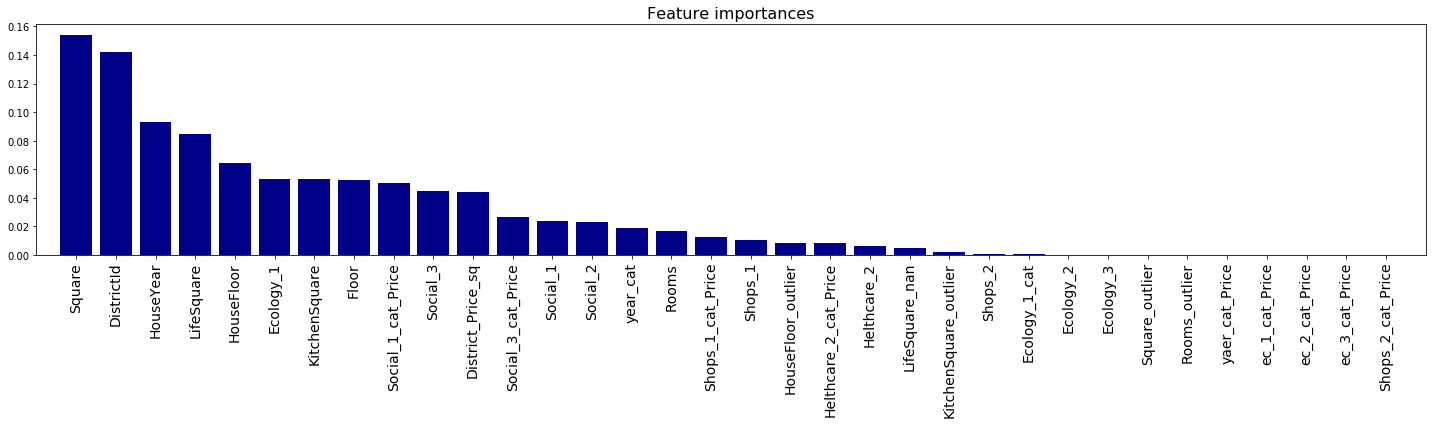

In [255]:
plot_feature_importances(model_LGBMR.feature_importances_, X_train_3)

In [253]:
model_LGBMR.feature_importances_

array([350,  42, 379, 208, 131, 130, 158, 230, 131,   0,   0,  58,  57,
       111,  16,  26,   2,   0,   5,  13,   0,  21, 108,  46,   0,   1,
         0,   0,   0, 125,  65,  20,  32,   0])

In [273]:
X_train_4=X.drop(['Price','Price_per_sq','Shops_2_cat_Price','ec_3_cat_Price','ec_2_cat_Price','ec_1_cat_Price',
                  'yaer_cat_Price','Rooms_outlier','Square_outlier','Ecology_3','Ecology_2','Ecology_1_cat'],axis=1)

In [300]:
cross_val_LGBMR(X_train_4,y_train)

R2: 0.764 +- 0.024


In [289]:
params_LGBMR={'n_estimators':[78,105,110],'max_depth':[16],'learning_rate': [0.1], 'num_leaves':[31]}
gs_LGBMR(X_train_4,y_train,params_LGBMR)

0.7609517359382523 {'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 78, 'num_leaves': 31}


In [335]:
model_LGBMR = LGBMRegressor(max_depth=18,
                             learning_rate=0.1,
                             n_estimators=100,
                             num_leaves=33,
                             random_state=42)

In [336]:
cv_score = cross_val_score(model_LGBMR, X_train_2, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.764 +- 0.023


In [341]:
X_final_4=X_final.drop(['Shops_2_cat_Price','ec_3_cat_Price','ec_2_cat_Price','ec_1_cat_Price',
                  'yaer_cat_Price','Rooms_outlier','Square_outlier','Ecology_3','Ecology_2','Ecology_1_cat'],axis=1)

In [343]:
final_model(X_train_4,y_train,X_final_4,preds_final,5,18,0.1,100,33)